In [1]:
import NSBij
import h5py
import json
import time
import pyccl
import scipy
import numpy
import random
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
def C_function(coefficients, phi_grid1, phi_grid2, grid_size):
    outer_product = numpy.outer(phi_grid1, phi_grid2)

    functions = numpy.sum(coefficients * outer_product[:, :, None], axis=(0, 1))
    
    return functions

In [3]:
#Data path

TYPE = 'NS'
PATH = '/pscratch/sd/y/yhzhang/TensorCloud/'

DATA_PATH = PATH + 'DATA/'
PLOT_PATH = PATH + 'PLOT/' + TYPE + '/'

In [4]:
#Load in Data

BIN_SIZE = 4
GRID_SIZE = 128
DATA_SIZE = 100000

with h5py.File(DATA_PATH + 'DATA.hdf5','r') as DATA:
    
    REDSHIFT_GRID = numpy.array(DATA['realizations/z'][:GRID_SIZE], dtype = 'float32')
    DATA_GRID = numpy.array(DATA['realizations/pdfs'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'float32')

In [5]:
# COSMOLOGY

with open(DATA_PATH + 'COSMO.json', 'r') as cosmo:
    
    COSMO = json.load(cosmo)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu = COSMO['MNU'],  
    Neff = COSMO['NEFF'],
    T_CMB = COSMO['TCMB'], 
    Omega_k = COSMO['OMEGAK'], 
    Omega_c = COSMO['OMEGAC'], 
    Omega_b = COSMO['OMEGAB'], 
    matter_power_spectrum = 'halofit',  
    transfer_function = 'boltzmann_camb', 
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 10000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [6]:
#Restrcture the data

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'float32')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

ELL_SIZE = 200
ELL_DATA = numpy.logspace(2, 4, ELL_SIZE + 1)
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, GRID_SIZE)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
for GRID_INDEX in range(GRID_SIZE):

    POWER_GRID[:,GRID_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

In [7]:
#Calculate the angular power spectra for different realizations
AMPLITUDE = 3 / 2 * (COSMO['OMEGAM'] + COSMO['OMEGAN']) * (COSMO['H'] * 100000 / scipy.constants.c)**2 * numpy.sqrt((1 + 3 / (2 * ELL_DATA + 1)) * (1 + 1 / (2 * ELL_DATA + 1)) * (1 - 1 / (2 * ELL_DATA + 1)) * (1 - 3 / (2 * ELL_DATA + 1)))
T0 = time.time()
d_uv = numpy.zeros((BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
DATA_SIZE_Cut = 10000
DATA_GRID = list(DATA_GRID)
DATA_GRID=random.sample(DATA_GRID, DATA_SIZE_Cut)
PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c
PHI_GRID_cut = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, GRID_SIZE))
varepsilon_GRID_cut = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, GRID_SIZE))
C_uv_re = numpy.zeros((DATA_SIZE_Cut, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
Bij=NSBij.function(amplitude = AMPLITUDE, chi_grid = CHI_GRID, power_grid = POWER_GRID, redshift_grid = REDSHIFT_GRID)
PHI_GRID_cut = DATA_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c
varepsilon_GRID_cut=PHI_GRID_cut-PHI_GRID
T1 = time.time()
print(T1 - T0)

3.3326971530914307


In [8]:
B_ij = numpy.zeros((DATA_SIZE_Cut,3, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1))
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for m1 in range(BIN_SIZE):
        for m2 in range(BIN_SIZE):
            C_uv_re[a][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID_cut[a][m1], phi_grid2 = PHI_GRID_cut[a][m2],grid_size=GRID_SIZE)
            B_ij[a][0][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID[m1], phi_grid2 = PHI_GRID[m2],grid_size=GRID_SIZE)
            B_ij[a][1][m1][m2]=C_function(coefficients = Bij, phi_grid1 = PHI_GRID[m1], phi_grid2 = varepsilon_GRID_cut[a][m2],grid_size=GRID_SIZE)
            B_ij[a][2][m1][m2]=C_function(coefficients = Bij, phi_grid1 = varepsilon_GRID_cut[a][m1], phi_grid2 = varepsilon_GRID_cut[a][m2],grid_size=GRID_SIZE)
average_C_uv_re = numpy.mean(C_uv_re, axis=0)
d_uv = d_uv + average_C_uv_re
T1 = time.time()
print(T1 - T0)

3955.5701529979706


In [9]:
#Calculate Gamma
Gamma_L = numpy.zeros((BIN_SIZE, BIN_SIZE, BIN_SIZE, BIN_SIZE, ELL_SIZE + 1, ELL_SIZE + 1))

for m1 in range(BIN_SIZE):
    for m2 in range(BIN_SIZE):
        for m1_prime in range(BIN_SIZE):
            for m2_prime in range(BIN_SIZE):
                for ell in range(ELL_SIZE + 1):
                    for ell_prime in range(ELL_SIZE + 1):
                        if m1 == m1_prime and m2 == m2_prime and ell == ell_prime:
                            Gamma_L[m1, m2, m1_prime, m2_prime, ell, ell_prime] = 1/(2*d_uv[m1][m2][ell]**2)

In [10]:
#Calculate third and Fourth order
Third_Fourth_order=numpy.zeros(DATA_SIZE_Cut)
nz = numpy.nonzero(Gamma_L)
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for idx in zip(*nz):
        m1, m2, m1_prime, m2_prime, ell, ell_prime = idx
        gamma_value = Gamma_L[idx]
        term1 = gamma_value * B_ij[a, 1, m2, m1, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        term2 = gamma_value * B_ij[a, 1, m1, m2, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        term3 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 1, m2_prime, m1_prime, ell_prime]
        term4 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 1, m1_prime, m2_prime, ell_prime]
        term5 = gamma_value * B_ij[a, 2, m1, m2, ell] * B_ij[a, 2, m1_prime, m2_prime, ell_prime]
        Third_Fourth_order[a] += term1 + term2 + term3 + term4 + term5
Third_Fourth_order *= -0.5
T1 = time.time()
print(T1 - T0)

159.3840835094452


In [ ]:
#Calculate All order
All_order=numpy.zeros(DATA_SIZE_Cut)
T0 = time.time()
for a in range(DATA_SIZE_Cut):
    for idx in zip(*nz):
        m1, m2, m1_prime, m2_prime, ell, ell_prime = idx
        gamma_value = Gamma_L[idx]
        All_order[a]=All_order[a]+(d_uv[m1][m2][ell]-C_uv_re[a][m1][m2][ell])*gamma_value*(d_uv[m1_prime][m2_prime][ell_prime]-C_uv_re[a][m1_prime][m2_prime][ell_prime])
All_order*= -0.5
First_Second_order=All_order-Third_Fourth_order
T1 = time.time()
print(T1 - T0)

105.15280032157898


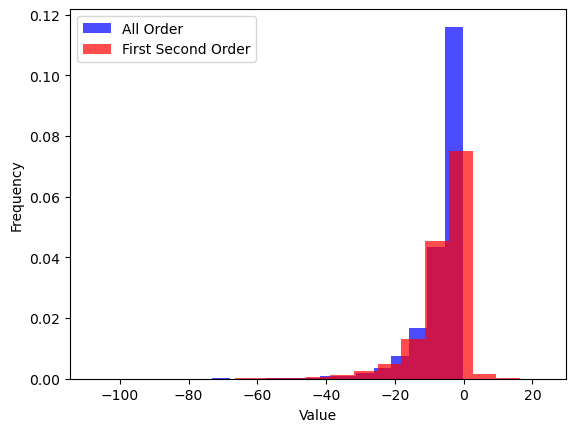

[-96.72953702 -91.50614353 -86.28275004 -81.05935655 -75.83596306
 -70.61256957 -65.38917608 -60.16578258 -54.94238909 -49.7189956
 -44.49560211 -39.27220862 -34.04881513 -28.82542164 -23.60202815
 -18.37863466 -13.15524117  -7.93184768  -2.70845419]
[3.82892846e-05 0.00000000e+00 0.00000000e+00 3.82892846e-05
 0.00000000e+00 7.65785692e-05 1.91446423e-05 3.82892846e-05
 1.91446423e-04 2.10591065e-04 3.82892846e-04 8.04074977e-04
 8.04074977e-04 1.85703030e-03 3.46518026e-03 7.37068729e-03
 1.67324174e-02 4.33626148e-02 1.16054822e-01]
[-104.37096007  -97.47111068  -90.5712613   -83.67141191  -76.77156253
  -69.87171314  -62.97186376  -56.07201438  -49.17216499  -42.27231561
  -35.37246622  -28.47261684  -21.57276745  -14.67291807   -7.77306869
   -0.8732193     6.02663008   12.92647947   19.82632885]
[2.89861400e-05 1.44930700e-05 0.00000000e+00 1.44930700e-05
 0.00000000e+00 7.24653499e-05 1.30437630e-04 2.02902980e-04
 3.47833680e-04 6.66681219e-04 1.14495253e-03 2.42034269e-03
 4.7

<Figure size 640x480 with 0 Axes>

In [ ]:
bin_num = 20
bins_1 = numpy.linspace(numpy.min(All_order),numpy.max(All_order), bin_num)
hist_all, bins_all = numpy.histogram(All_order, bins=bins_1, density=True)
bins_2 = numpy.linspace(numpy.min(First_Second_order),numpy.max(First_Second_order), bin_num)
hist_first_second, bins_first_second = numpy.histogram(First_Second_order, bins=bins_2, density=True)
bins_center1 = (bins_1[:-1] + bins_1[1:]) / 2
bins_center2 = (bins_2[:-1] + bins_2[1:]) / 2
bar_width1 = numpy.diff(bins_1)  
bar_width2 = numpy.diff(bins_2)  

pyplot.bar(bins_center1, hist_all, width=bar_width1, color='blue', label='All Order', alpha=0.7)
pyplot.bar(bins_center2, hist_first_second, width=bar_width2, color='red', label='First Second Order', alpha=0.7)


pyplot.legend()

pyplot.xlabel('Value')
pyplot.ylabel('Frequency')

pyplot.show()
pyplot.savefig(PLOT_PATH + 'second_NS.pdf', bbox_inches = 'tight')
print(bins_center1)
print(hist_all)
print(bins_center2)
print(hist_first_second)

In [ ]:
print(All_order[:5])
print(First_Second_order[:5])
print(Third_Fourth_order[:5])

[ -1.82172008  -3.2889207  -24.68608167 -15.66697061  -5.30231025]
[ -1.81044853  -2.87462014 -24.89933632 -16.50143677  -3.26763261]
[-0.01127155 -0.41430057  0.21325465  0.83446616 -2.03467764]


In [ ]:
print(All_order)
print(First_Second_order)
print(Third_Fourth_order)

[ -1.82172008  -3.2889207  -24.68608167 ...  -1.24709369 -10.88258201
  -4.90182007]
[ -1.81044853  -2.87462014 -24.89933632 ...  -2.5895624  -10.7746546
  -4.61941741]
[-0.01127155 -0.41430057  0.21325465 ...  1.34246871 -0.1079274
 -0.28240266]
